In [23]:
%pip install pandas
%pip install scipy
import json
import pandas as pd
import os
import subprocess
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, freqz, lfilter, lfilter_zi
from scipy.signal import find_peaks

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
def convert_to_seconds(timestamp):
    # Remove BOM if present
    if timestamp.startswith('\ufeff'):
        timestamp = timestamp[1:]    
    # Parse the timestamp string to a datetime object
    dt = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%fZ')
    # Convert the datetime object to seconds since the Unix epoch
    seconds = (dt - datetime(1970, 1, 1)).total_seconds()
    return seconds

In [25]:
def extract_processed_data_from_csv(file_path):

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Drop any rows that are completely NaN
    df.dropna(how='all', inplace=True)
    
    # Fill or drop NaN values in specific columns as needed
    df.ffill(inplace=True)  # Forward fill for simplicity, adjust as needed
    df.dropna(inplace=True)  # Drop rows if any NaN values remain after forward fill
    
    # Ensure all numerical columns are of the correct type
    for column in df.columns:
        if column not in ['Time (ms)', 'Estimated HR (Hz)', 'Estimated HR (bpm)', 'Time to next peak (ms)', 'Heart rate pulse interval (ms)', 'Red LED ADC', 'IR LED ADC', "Filtered", "ZeroCross"]:
            continue
        df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # Handle any remaining NaNs if conversion resulted in them
    df.fillna(0, inplace=True)  # Fill NaNs with 0, adjust as necessary for your use case

    return df


In [26]:
# Function to create a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

Filtering data with lowcut = 0.75 and highcut = 3.0


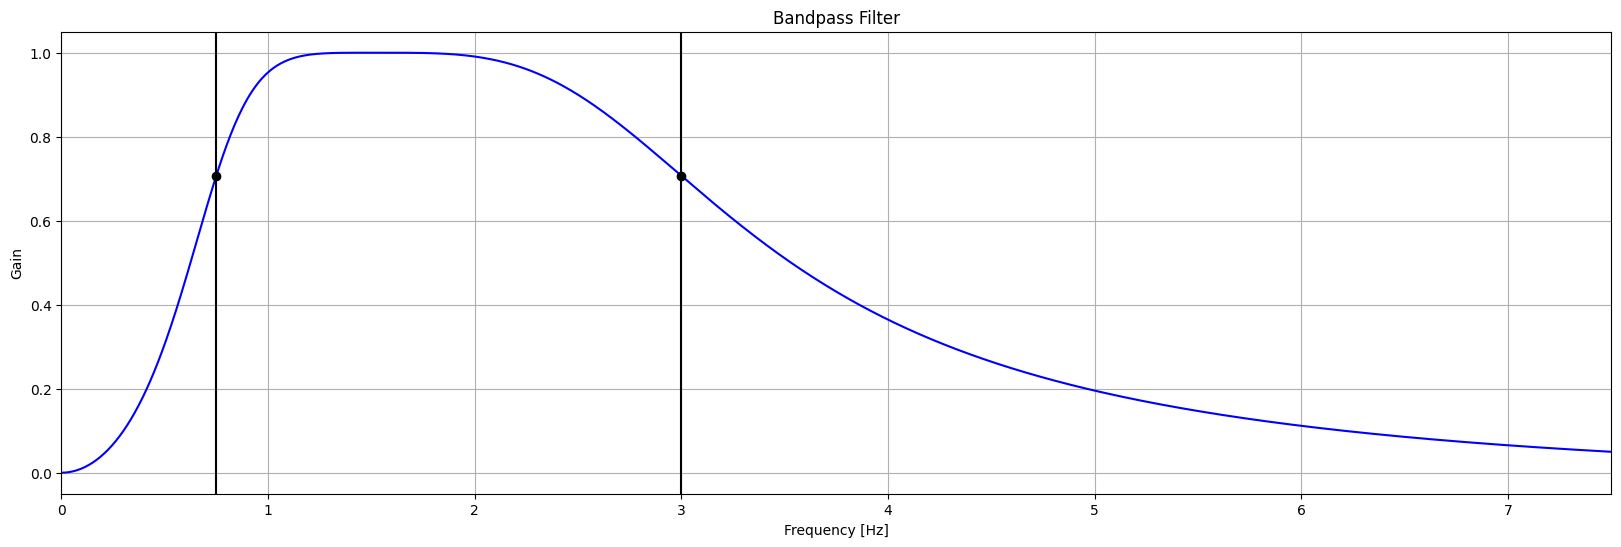

Note that there are 5 coefficients for order 2 bandpass filter since it creates a 2nd order filter for each bandpass element
b coefficients: [ 0.05644846  0.         -0.11289692  0.          0.05644846]
a coefficients: [ 1.         -2.99198635  3.52764744 -1.97218019  0.45044543]
Initial conditions (zi): [-0.05644846 -0.05644846  0.05644846  0.05644846]


In [27]:
# Filter design
fs = 25.0  # Sample rate, Hz
lowcut = 0.75  # Desired low cut frequency of the filter, Hz
highcut = 3.0  # Desired high cut frequency of the filter, Hz
filter_order = 2

# Design the bandpass filter
print("Filtering data with lowcut = {} and highcut = {}".format(lowcut, highcut))
b, a = butter_bandpass(lowcut, highcut, fs, order=filter_order)

# Plot the frequency response of the filter
w, h = freqz(b, a, worN=2000)
plt.figure(figsize=(20, 6))
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.plot(lowcut, 0.5 * np.sqrt(2), 'ko')
plt.axvline(lowcut, color='k')
plt.plot(highcut, 0.5 * np.sqrt(2), 'ko')
plt.axvline(highcut, color='k')
plt.xlim(0, 0.3 * fs)
plt.title("Bandpass Filter")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()

# Initial conditions (assuming zero initial conditions for simplicity)
zi = lfilter_zi(b, a)

print(f"Note that there are {len(b)} coefficients for order {filter_order} bandpass filter since it creates a 2nd order filter for each bandpass element")
print("b coefficients:", b)
print("a coefficients:", a)
print("Initial conditions (zi):", zi)


In [32]:
def process_using_cpp(el):

    input_file = os.path.join("data", el["adc_file"])
    # Run analysis CLI program in HRMAnalysisCPPCLI folder and called HRMAnalysisCPPCLI
    # The program takes two params: the input file and the output file
    subprocess.run(["./HRMAnalysisCPPCLI/HRMAnalysisCPPCLI", input_file, input_file + "_PROCESSED.csv"])


In [37]:
el = {"adc_file": "20241101 HTM data short.csv"}
process_using_cpp(el)

Output written to data/20241101 HTM data short.csv_PROCESSED.csv


In [51]:
def process_file(el):
    try:
        process_using_cpp(el)
        input_file = os.path.join("data", el["adc_file"])
        processed_data = extract_processed_data_from_csv(input_file + "_PROCESSED.csv")

        # Check if zoom_analysis range is valid
        start_idx = el['zoom_analysis'][0]
        end_idx = el['zoom_analysis'][1]

        if start_idx < 0:
            start_idx = 0
        if end_idx >= len(processed_data):
            end_idx = len(processed_data) - 1

        # Extract range of interest
        zoomed_data = processed_data.iloc[start_idx:end_idx]

        # Set plot size to full width
        plt.rcParams["figure.figsize"] = (20, 6)

        # Plot Red ADC, filtered and zero crossing points on different Y axes
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        timeS = zoomed_data["Time (ms)"] / 1000
        red_adc = zoomed_data["Red LED ADC"]
        filtered = zoomed_data["Filtered"]
        zero_cross = zoomed_data["ZeroCross"]

        ax1.plot(timeS, red_adc, label="Red LED ADC", color='red')
        ax2.plot(timeS, filtered, label="Filtered", color='blue')

        # Plot vertical lines for ZeroCross points
        first_line = True
        for t, zc in zip(timeS, zero_cross):
            if zc != 0:
                ax2.axvline(x=t, color='green', linestyle='--', label="ZeroCross" if first_line else "")
                first_line = False

        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Red LED measurement", color='red')
        ax2.set_ylabel("Filtered", color='blue')
        ax1.set_title("Red LED, Filtered and Zero-Crossings vs Time")

        # Combine legends from both axes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc="upper right")

        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")

    # Check if zoom_analysis range is valid
    start_idx = el['comparison_analysis'][0]
    end_idx = el['comparison_analysis'][1]

    if start_idx < 0:
        start_idx = 0
    if end_idx >= len(processed_data):
        end_idx = len(processed_data) - 1

    # Skip the initial samples
    comparison_data = processed_data.iloc[start_idx:end_idx]

    # Plot the Filtered value vs time for the whole range
    plt.plot(comparison_data["Time (ms)"] / 1000, comparison_data["Filtered"], label="Filtered")
    plt.xlabel("Time (s)")
    plt.ylabel("Red LED ADC")
    plt.title("Red LED ADC vs Time")
    plt.legend()
    plt.show()
    
    # Plot the Estimated HR (bpm) vs time
    plt.plot(comparison_data["Time (ms)"] / 1000, comparison_data["Estimated HR (bpm)"], label="Estimated HR (bpm)")
    plt.xlabel("Time (s)")
    plt.ylabel("HRM")
    plt.title("HRM vs Time")
    plt.legend()
    plt.show()


In [54]:
el = {
    "adc_file": "20241031 HRM data 76 - 120 - 89.csv",
    # "adc_file": "20241031 HRM data 1st 160 rows.csv",
    # "adc_file": "20241101 HTM data short.csv",
    "waypoint_name": "Waypoint 1",
    "waypoint_rel_time": 0,
    "zoom_analysis": [200, 1000],
    "comparison_analysis": [200, 1000]
}

Output written to data/20241031 HRM data 76 - 120 - 89.csv_PROCESSED.csv
0    2258461
1    2258192
2    2257885
3    2257998
4    2258214
Name: Red LED ADC, dtype: int64


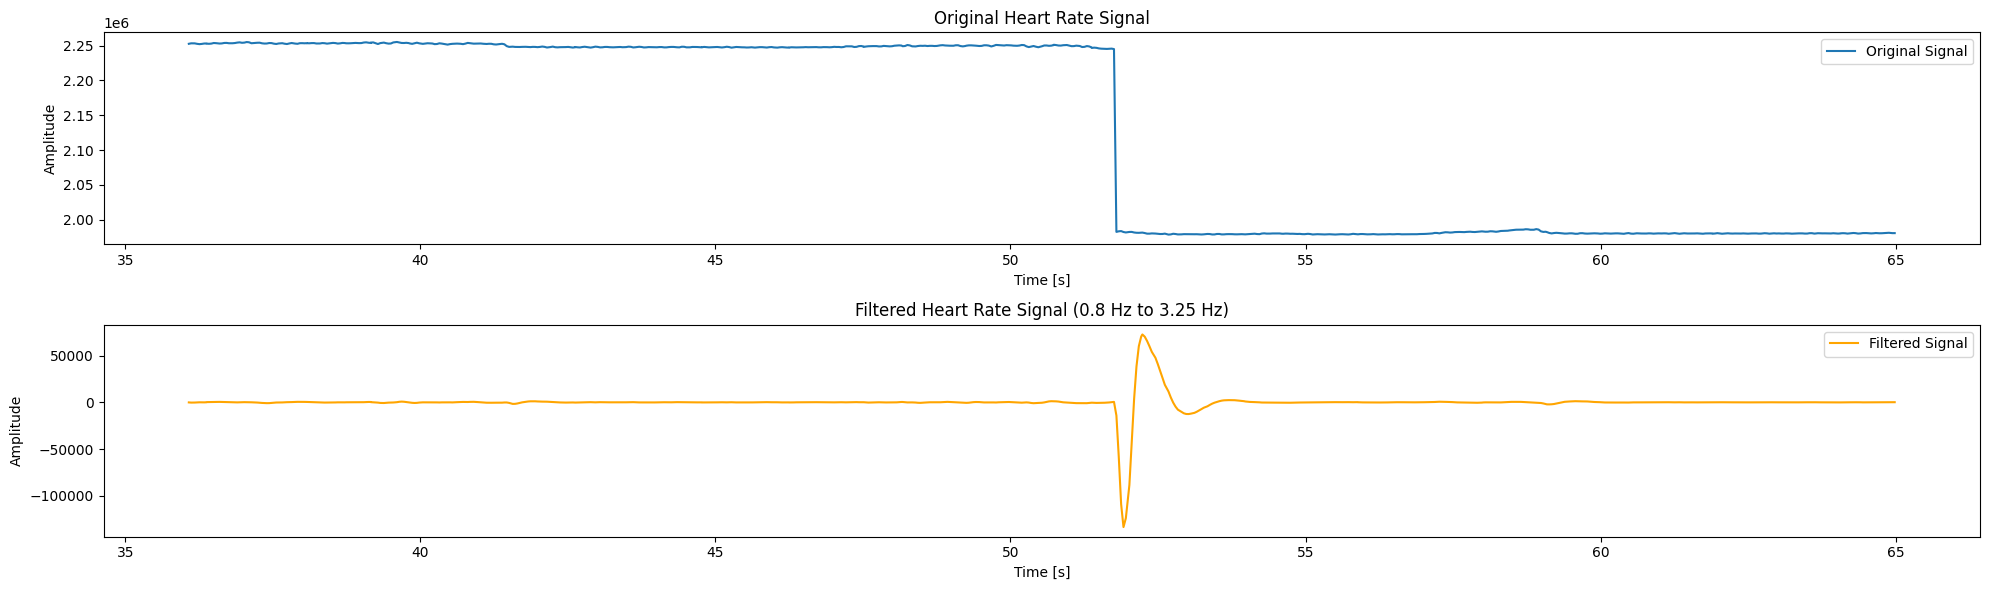

In [55]:
# Test filter with file
process_using_cpp(el)
processed_data = extract_processed_data_from_csv(os.path.join("data", el["adc_file"]) + "_PROCESSED.csv")
t = processed_data["Time (ms)"] / 1000
hr_data = processed_data["Red LED ADC"]
print(hr_data.head())

# Apply the bandpass filter
filtered_hr_data = bandpass_filter(hr_data, lowcut, highcut, fs, order=filter_order)
# print(filtered_hr_data[0:100])

# Skip initial samples
plot_start = 300
plot_end = 1000

# Plot the original and filtered signals
plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(t[plot_start:plot_end], hr_data[plot_start:plot_end], label='Original Signal')
plt.title('Original Heart Rate Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[plot_start:plot_end], filtered_hr_data[plot_start:plot_end], label='Filtered Signal', color='orange')
plt.title('Filtered Heart Rate Signal (0.8 Hz to 3.25 Hz)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

Output written to data/20241031 HRM data 76 - 120 - 89.csv_PROCESSED.csv


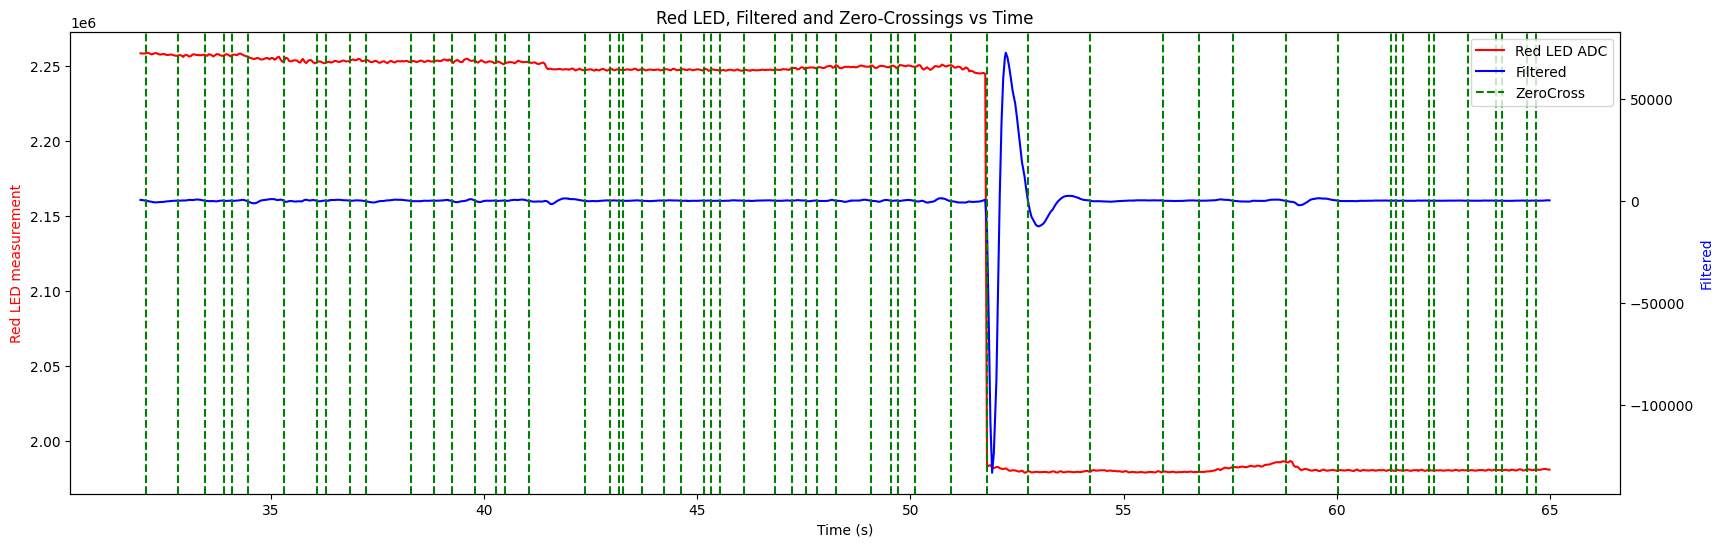

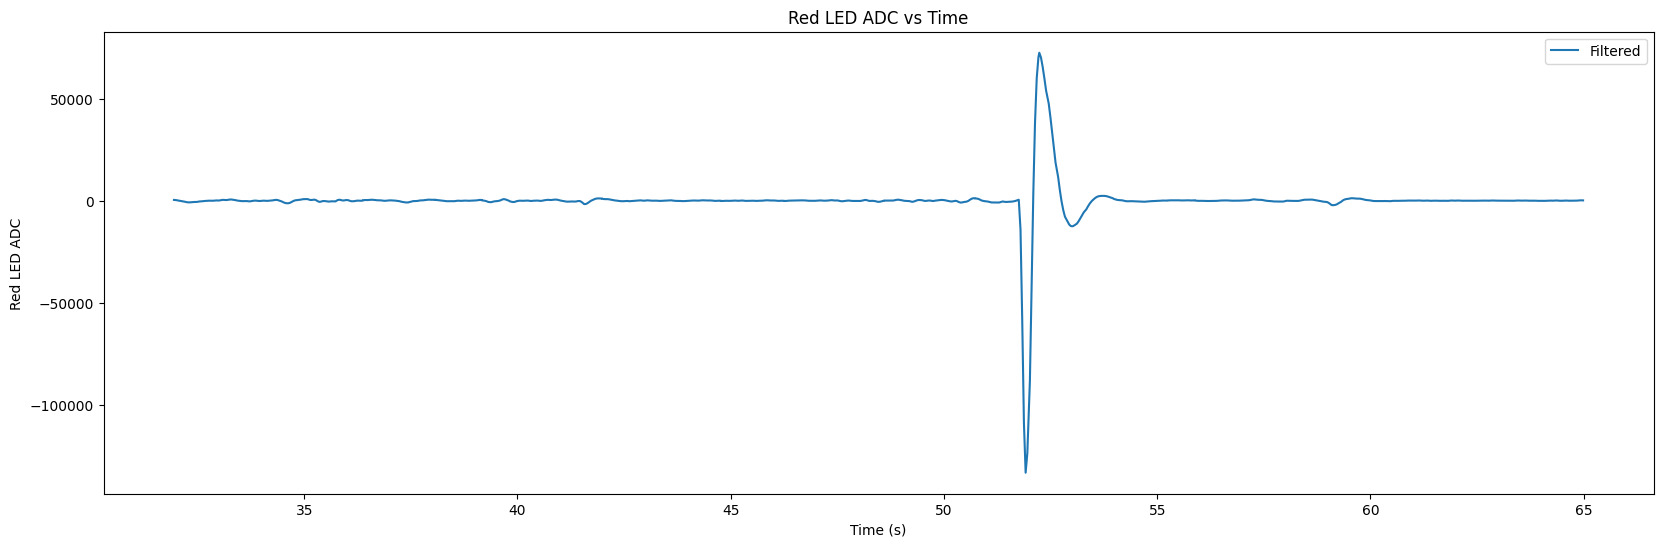

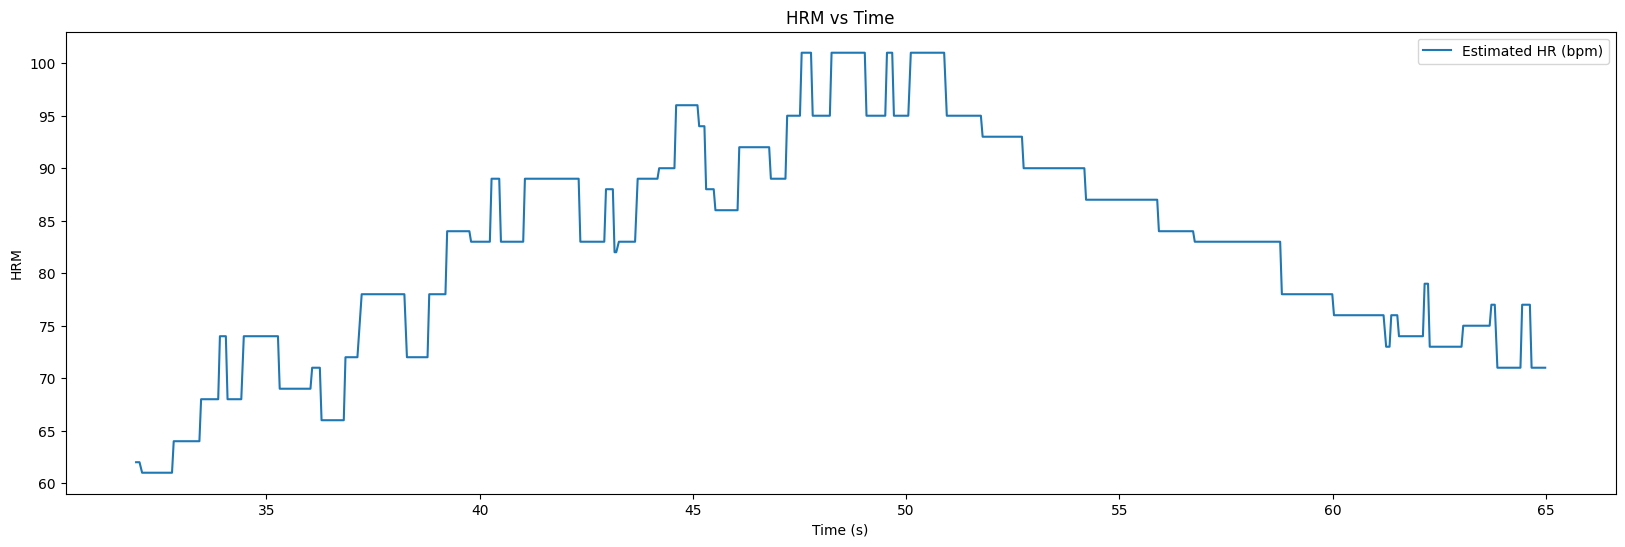

In [56]:
process_file(el)
